## Data Science Lifecyle: Transition Probability Analysis

In [1]:
# import libraries
import os 
from os import listdir
from os.path import isfile, join
from os.path import dirname as up

import random
import json
import numpy as np
import pandas as pd
from shutil import copyfile,copy
import itertools
from glob import glob
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# set path
path = os.getcwd()

features_path = os.path.join(path,'features','')
results_path = os.path.join(path,'results','f_transition_probabilities','')

if os.path.exists(results_path):
    pass
else:
    os.mkdir(results_path)

In [3]:
# load the features of notebook dataset
features_df = pd.read_pickle(features_path+'f_DASWOW.pkl') 
df = features_df.copy()
df.index = range(features_df.shape[0])
df['execution_count'].fillna(-1,inplace=True) # if no execution count is available, set it to -1
print(len(set(df.filename.values)),features_df.shape)

470 (9678, 32)


In [4]:
### steps in a data science notebook life cycle
labels = ['helper_functions','load_data','data_exploration','data_preprocessing',
              'modelling','evaluation','prediction','result_visualization','save_results','comment_only']

In [5]:
filegroup = df.groupby(['filename'])
label_count_per_cell = df[labels].sum(axis=1).values
print("no. of cells with single label in the dataset: {0}".format(len([l for l in label_count_per_cell if l==1])))
all_nbs = list(set(df.filename.values))

no. of cells with single label in the dataset: 7368


In [6]:
#### number of cells with only one label
single_label_indices = [i for i in range(df.shape[0]) if label_count_per_cell[i]== 1]
df.iloc[single_label_indices].shape

#### number of notebooks with only one label per cell
single_label_nbs = []
for k,v in filegroup:
    if len(v.index.values) == len(set(single_label_indices).intersection(set(v.index.values))):
        single_label_nbs.append(k)
print("no. of cells with one label per cell throughout: {0} equaling {1:.2f}% of the dataset".format(len(single_label_nbs),len(single_label_nbs)/len(set(df.filename.values))*100))

#### get a dataframe with notebooks that have only one labels per cell throughout
single_label_df = df[df.filename.isin(single_label_nbs)]

#check that the notebooks have only one label per cell throughout
label_count = single_label_df[labels].sum(axis=1).values
set(label_count)

no. of cells with one label per cell throughout: 41 equaling 8.72% of the dataset


{1}

In [7]:
def plot_transition_matrix(mat,freq,typ):
    if typ == 'no':
        labels = (np.asarray(["{0:.2f} \n [{1}]".format(pvalue,fvalue) for pvalue,fvalue in zip(mat.to_numpy().flatten(),freq.to_numpy().flatten())])).reshape(mat.shape[0],mat.shape[1])        
    else:
        labels = (np.asarray(["{0:.2f} \n [{1:.2f}%]".format(pvalue,fvalue) for pvalue,fvalue in zip(mat.to_numpy().flatten(),freq.to_numpy().flatten())])).reshape(mat.shape[0],mat.shape[1])        
        
    fig,ax = plt.subplots(figsize=(12,9))
    ax = sns.heatmap(
        mat,
        annot = labels,
        fmt = "",
        cmap=sns.diverging_palette(20, 220, n=200),
        linewidths = 1,
        robust=True, center=0
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right'
    );
    
    ax.set_xlabel("next state",fontsize=12,fontweight='bold')
    ax.set_ylabel("current state",fontsize=12,fontweight='bold')

In [8]:
dfpred = pd.read_pickle(os.path.join(path,'results','multi-label-classification','')+'prediction_multi.pkl')
pred_nbs = list(set(dfpred.filename.values))
pred_filegroup = dfpred.groupby(['filename'])

### N-order markov analysis 

In [9]:
#set states for calculating transition probabilities
states = ['start','helper_functions','load_data','data_exploration','data_preprocessing',
              'modelling','evaluation','prediction','result_visualization','save_results','comment_only','stop']

In [10]:
# calculate possible starting states
n = 1 # set n for n-order markov
t = 0

current_states = [perm for perm in itertools.permutations(states, n)]
for s in states:
    tup = tuple([s]*n)
    sval = [s[0] for s in current_states]
    if tup not in current_states:
        ind = max(loc for loc, val in enumerate(sval) if val == s)+states.index(s)
        if t == 0:
            t = max(loc for loc, val in enumerate(sval) if val == s)
        else:
            t = t+1
        current_states.insert(ind-t,tup)
for i in range(len(current_states)):
    if len(current_states[i])==1:
        current_states[i] = current_states[i][0]


### Extract the transitions
all_nbs for true label probabilities stored in tmatrix1
and 
pred_nbs for prediction label probabilities stored in tmatrix2

In [11]:
#### extract the transactions
prob_strategy = 'equal'
transitions,t_freq = {},{}

for nb in pred_nbs: 
    osequence = [['start']]
    for each in pred_filegroup.get_group(nb)[labels].values: #filegroup for true and pred_filegroup for prediction
        osequence.append([labels[i] for i in range(len(each)) if each[i]==1])
    osequence.append(['stop'])
    sequence = osequence.copy()
    for i in range(len(sequence)):
        if i < len(sequence)-n:
            key = sequence[i] 
            value = sequence[i+n] #next state      
            
            sstates = []
            for each in key:
                if type(each)==list:
                    for e in each:
                        sstates.append(e)
                else:
                    sstates.append(each)
            tstates = []
            for each in value:
                if type(each)==list:
                    for e in each:
                        tstates.append(e)
                else:
                    tstates.append(each)
            start_states = [perm for perm in itertools.permutations(sstates, len(sstates))] 
            terminal_states = [perm for perm in itertools.permutations(tstates, len(tstates))] 
            prob_weight = 1/(len(start_states)*len(terminal_states))
            for s in start_states:
                for t in terminal_states:
                    sseq = list(s+t)
                    #print(sseq)
                    for j in range(len(sseq)):
                        if j < len(sseq)-1:
                            k = sseq[j] 
                            v = sseq[j+n] #next state
                            if k not in transitions.keys():
                                transitions[k],t_freq[k] = {},{}
                                if (prob_strategy == 'equal') or (prob_weight==1):
                                    transitions[k][v] = prob_weight
                                else:
                                    transitions[k][v] = tmatrix1_prob.loc[k][v]
                                t_freq[k][v] = 1
                            else:
                                if v not in transitions[k].keys():
                                    if (prob_strategy == 'equal') or (prob_weight==1):
                                        transitions[k][v] = prob_weight
                                    else:
                                        transitions[k][v] = tmatrix1_prob.loc[k][v]
                                    t_freq[k][v] = 1
                                else:
                                    if (prob_strategy == 'equal') or (prob_weight==1):
                                        transitions[k][v] = transitions[k][v]+prob_weight
                                    else:
                                        transitions[k][v] = transitions[k][v]+tmatrix1_prob.loc[k][v]
                                    t_freq[k][v] = t_freq[k][v]+1
            #print()
            

In [12]:
print("possible current states: ",len(current_states), 
      "actual current states: ", len(set(current_states).intersection(set(transitions.keys()))))

possible current states:  12 actual current states:  11


In [13]:
### print out frequencies: which current sequences occur mostly
unsorted_frequency_dict = {k: sum(v.values()) for k,v in transitions.items()} #sum(v.values()) or len(v)
frequency_dict = dict(sorted(unsorted_frequency_dict.items(), key=lambda item: item[1], reverse=True))

In [14]:
### generate transition matrix
tmatrix_cols = states[:]
tmatrix_cols.remove('start')

In [15]:
if n == 1:
    tmatrix_rows = [s for s in current_states if s in set(transitions.keys())]
elif n == 2:
    new_states = [(val[1],val[0]) for val in current_states]
    #print(new_states)
    tmatrix_rows = [s for s in new_states if s in set(transitions.keys())]
print(tmatrix_rows,tmatrix_cols)

['start', 'helper_functions', 'load_data', 'data_exploration', 'data_preprocessing', 'modelling', 'evaluation', 'prediction', 'result_visualization', 'save_results', 'comment_only'] ['helper_functions', 'load_data', 'data_exploration', 'data_preprocessing', 'modelling', 'evaluation', 'prediction', 'result_visualization', 'save_results', 'comment_only', 'stop']


### Trnasition matrix with all labels using equal probability strategy

In [16]:
# for true transitions, execute this
transitions_all_equal = transitions
t_freq_all_equal = t_freq

In [17]:
# for prediction transitions, execute this
predtransitions_all_equal = transitions
predt_freq_all_equal = t_freq

In [18]:
### generate transition matrix
tmatrix = pd.DataFrame(index=pd.Index(tmatrix_rows), columns = tmatrix_cols)
for k,v in transitions.items():
    c = Counter(v)
    #print(k,c)
    for key,val in c.items():
        #print(k,key,val)
        tmatrix.loc[k,key] = round(val,2)
tmatrix.fillna(0,inplace=True)

In [19]:
tmatrix1_freq = tmatrix.reindex(tmatrix_rows)
tmatrix2_freq = tmatrix.reindex(tmatrix_rows)

In [20]:
# calculate transition probabilities
tmatrix.loc[:,tmatrix_cols] = tmatrix.loc[:,tmatrix_cols].div(tmatrix.sum(axis=1), axis=0)

In [21]:
tmatrix1_prob = tmatrix.reindex(tmatrix_rows)
tmatrix2_prob = tmatrix.reindex(tmatrix_rows)

In [22]:
tmatrix1 = tmatrix.reindex(tmatrix_rows).copy()
tmatrix2 = tmatrix.reindex(tmatrix_rows).copy()

In [23]:
tmatrix1_prob.to_pickle(results_path+'truetmequal.pkl')
tmatrix2_prob.to_pickle(results_path+'predtmequal.pkl')

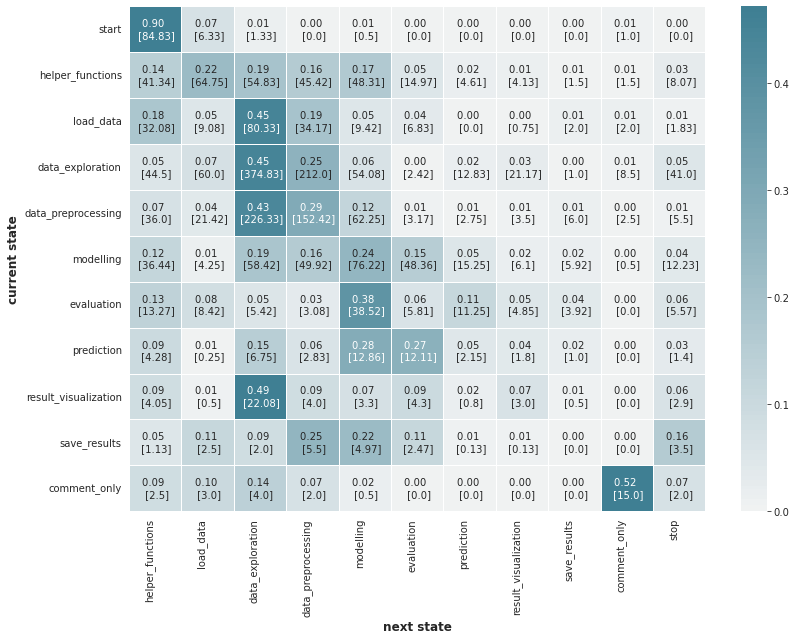

In [24]:
plot_transition_matrix(tmatrix1,tmatrix1_freq,'no')
plt.tight_layout()
plt.savefig(results_path+'transitionprobabilitiesequal.eps',format='eps')
# Show the plot
plt.show()

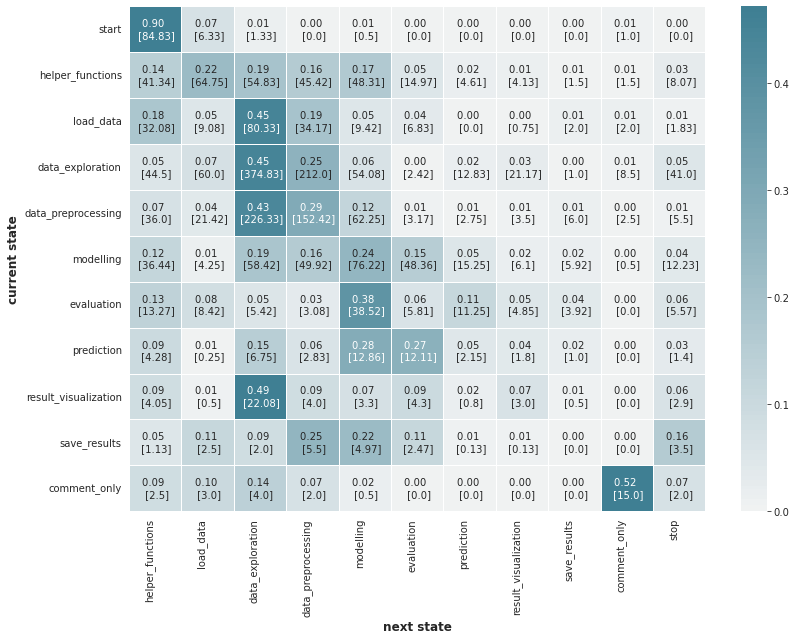

In [25]:
tmatrix2_prob.to_pickle(results_path+'predtmequal.pkl')
plot_transition_matrix(tmatrix2,tmatrix2_freq,'no')
plt.tight_layout()
plt.savefig(results_path+'transitionprobabilitiespred.eps',format='eps')
# Show the plot
plt.show()

## Correlation Analysis
between the transition probabilities of true set states and predicted set states

In [26]:
#comparison of true transitional probabilities vs prediction transition probabilities
corr = tmatrix1.corrwith(tmatrix2, axis = 1, method='kendall')
print(corr)
print(np.mean(corr.values))
#corr.to_latex()

start                   1.0
helper_functions        1.0
load_data               1.0
data_exploration        1.0
data_preprocessing      1.0
modelling               1.0
evaluation              1.0
prediction              1.0
result_visualization    1.0
save_results            1.0
comment_only            1.0
dtype: float64
1.0


In [27]:
from sklearn.metrics import mean_squared_error 
from scipy.stats import spearmanr,kendalltau
    
# calculate kendall's correlation
for l in tmatrix1.index.values:
    print(l)
    coef, p = kendalltau(tmatrix1.loc[l], tmatrix2.loc[l])
    print('Kendall correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    print()

start
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

helper_functions
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

load_data
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

data_exploration
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

data_preprocessing
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

modelling
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

evaluation
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

prediction
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

result_visualization
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

save_results
Kendall correlation coefficient: 1.000
Samples are correlated (reject H0) p=0.000

comment_only
Kendall correlation co

### Sankey visualisation

In [28]:
tmatrix1 = pd.read_pickle(results_path+'truetmequal.pkl')
tmatrix2 = pd.read_pickle(results_path+'predtmequal.pkl')

In [29]:
sankey_label = ['start',
 'helper_functions',
 'load_data',
 'data_exploration',
 'data_preprocessing',
 'modelling',
 'evaluation',
 'prediction',
 'result_visualization',
 'save_results',
 'comment_only',
 'stop']

colors = ['rgba(31, 119, 180, 0.8)',
 'rgba(255, 127, 14, 0.8)',
 'rgba(44, 160, 44, 0.8)',
 'rgba(214, 39, 40, 0.8)',
 'rgba(148, 103, 189, 0.8)',
 'rgba(140, 86, 75, 0.8)',
 'rgba(227, 119, 194, 0.8)',
 'rgba(127, 127, 127, 0.8)',
 'rgba(188, 189, 34, 0.8)',
 'rgba(23, 190, 207, 0.8)',
 'rgba(181, 11, 180, 0.8)',
 'rgba(255, 127, 14, 0.8)']

In [30]:
#probability_sankey
source,target,value = [],[],[]
for s in tmatrix1.index.values:
    for t in tmatrix1.columns.values:
        pval = round(tmatrix1.loc[s][t],2)
        if pval>=0.05:
            source.append(sankey_label.index(s))
            target.append(sankey_label.index(t))
            value.append(pval)
            
link_colors = [colors[src].replace("0.8", str(0.5))
                                    for src in source]

In [31]:
import plotly.graph_objects as go

def plot_sankey(sankey_label,colors,source,target,value,link_colors,title):
    fig = go.Figure(data=[go.Sankey(
        valueformat = ".0f",
        valuesuffix = "",
        orientation = "v",
        # Define nodes
        node = dict(
          pad = 30,
          thickness = 15,
          line = dict(color = "black", width = 0.8),
          label = sankey_label,
          color = colors,
        #x= [-0.05, 0.1, 0.2, 0.33, 0.43, 0.58, 0.7, 0.8, 0.9,  -0.05, -0.05, 0],
        #y= [0.5,   0.6, 0.55, 0.6, 0.5,  0.6, 0.55, 0.6,  0.55,   0.1, 0.3, 0.1]
        ),
        # Define links
        link = dict(
          source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = value,
            label = value,
          color = link_colors
      ))])

    fig.update_layout(
        autosize=False,
        width=1800,
        height=1300,
        font_size=9)
    fig.write_image(results_path+title+".pdf")
    #fig.show(renderer='svg')
    
    

In [32]:
# p>=0.00 (equal strategy)
plot_sankey(sankey_label,colors,source,target,value,link_colors,"truesankeydiagram")


In [33]:
#probability_sankey
source,target,value = [],[],[]
for s in tmatrix2.index.values:
    for t in tmatrix2.columns.values:
        pval = round(tmatrix2.loc[s][t],2)
        if pval>=0.05:
            source.append(sankey_label.index(s))
            target.append(sankey_label.index(t))
            value.append(pval)
            
link_colors = [colors[src].replace("0.8", str(0.5))
                                    for src in source]

In [34]:
# p>0.02 (equal strategy)
plot_sankey(sankey_label,colors,source,target,value,link_colors,"predictedsankeydiagram")